## Проверка шаблона

Перед классификацией патента (т.е. к какому классу патентов он относится), необходимо провести проверку, что он удовлетворяет требованиям оформления. В качестве шаблона был взят шаблон из примеров файлов по следующей ссылке: https://neustel.com/patents/sample-patents/

In [ ]:
!pip install pdfminer.six

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 13.7 MB/s eta 0:00:00


In [ ]:
import re
from io import StringIO
import pdfminer as miner
from pdfminer.layout import LAParams
from pdfminer.high_level import extract_text_to_fp

def extract_text_from_pdf(file_path):

    output_string = StringIO()

    with open(file_path, 'rb') as file:
        extract_text_to_fp(file, output_string, laparams=LAParams(), page_numbers=[0, 1])

    return output_string.getvalue()

def process_text(text):

    patterns = [
    (r"(.*?)(\(57\).*)", r"\1", "sub"),
    (r"(\(12\).*)", None, "search"),
    (r"(\(51\).*?)(\(74\))", r"\2", "sub"),
    (r"(\(54\).*?)(\(76\))", r"\2", "sub"),
    (r"\(\s*\*\s*\).*?\(22\)", "", "sub"),
    # (r"Filed.*?\(74\)", "", "sub"),
    # (r"Filed.*?\(60\)", "", "sub"),
    # (r"Filed.*", "", "sub")
    ]

    for pattern, replacement, action in patterns:
        if action == "sub":
            text = re.sub(pattern, replacement, text, flags=re.DOTALL)
        elif action == "search":
            match = re.search(pattern, text, re.DOTALL)
            if match:
                text = match.group(1)

    return text

def extract_all_sections(text):
    pattern = r"\((\d{1,3})\)"

    sections = [match for match in re.finditer(pattern, text)]

    content_between_sections = []

    for i in range(len(sections)-1):
        start_section = int(sections[i].group(1))
        end_section = int(sections[i+1].group(1))

        if 1 <= start_section <= 200 and 1 <= end_section <= 200:
            start_index = sections[i].end()
            end_index = sections[i+1].start()
            content = text[start_index:end_index].strip()

            content_between_sections.append(f'({start_section})' + content)

    content_between_sections.append(text[sections[len(sections)-1].start():])
    return content_between_sections

def process_text_items(text_items):
    processed_items = []
    patent_no = ""

    for item in text_items:
        if "Bl" in item and any(char.isdigit() for char in item):
            item_copy = item
            item_lst = item_copy.split('\n')
            for i in range(len(item_lst)):
              if "Bl" in item_lst[i]:
                patent_no = item_lst[i]
                break

        if item.startswith('(45)Date of Patent:'):
            date_match = re.search(r"(\b\w{3}\.?\s+\d{1,2},\s+\d{4}\b)", item)
            if date_match:
                date = date_match.group(0)
                item = f'(45)Date of Patent: {date}'

        processed_items.append(item)

    for i in range(len(processed_items)):
      if '(10)Patent No.:' in processed_items[i]:
        processed_items[i] = f'(10)Patent No.: {patent_no}'

    return processed_items

file_path = "/content/drive/MyDrive/PatentClassification/Sample-Patent_Railroad_Flangeway_Cleaner_System.pdf"
text = extract_text_from_pdf(file_path)
processed_text = process_text(text)
list_text = extract_all_sections(processed_text)
processed_list = process_text_items(list_text)

for item in processed_list:
    print(item)

match_12 = any("(12)United States Patent" in item for item in processed_list)
match_10 = any("(10)Patent No.: US" in item for item in processed_list)
match_45 = any("(45)Date of Patent:" in item for item in processed_list)
match_76 = any("(76)Inventor:" in item for item in processed_list)

if match_12 and match_10 and match_45 and match_76:
    print("The document matches the template")
else:
    print("The document does not match the template")


(12)United States Patent 

Neustel
(10)Patent No.: US 8,036,493 Bl 
(45)Date of Patent: Oct. 11, 2011
(76)Inventor: 

Michael S. Neustel, Fargo, ND (US) 

  Filed: 

Mar. 27, 2007 

Related U.S. Application Data
(60)Provisional application No.  601743,794, filed on Mar.
(74)  Attorney, Agent, or Firm - Michael S.  Neustel 


The document matches the template


## Выделение содержания

In [ ]:
from pdfminer.high_level import extract_text_to_fp
from pdfminer.layout import LAParams
from io import StringIO

def extract_text_from_pdf(file_path):
    output_string = StringIO()

    with open(file_path, 'rb') as file:
        extract_text_to_fp(file, output_string, laparams=LAParams())

    extracted_text = output_string.getvalue()

    background_index = extracted_text.find("BACKGROUND OF THE INVENTION")

    if background_index != -1:
        text_after_background = extracted_text[background_index + len("BACKGROUND OF THE INVENTION"):].strip()
        return text_after_background.replace('\n\n', ' ')
    else:
        return "Background section not found in the document."

file_path = "/content/drive/MyDrive/PatentClassification/Sample-Patent_Railroad_Flangeway_Cleaner_System.pdf"
text_after_background = extract_text_from_pdf(file_path)
print(text_after_background)


15  20  1.  Field of the Invention 
The  present  invention relates  generally  to  patent images 
and  more  specifically  it  relates  to  a  method  for  correcting 
orientation of patent figures  for increasing the efficiency of  25 
reviewing the figures of a patent.  2.  Description of the Related Art 
Any discussion of the prior art throughout the specification 
should in no  way be considered as  an admission that  such 
prior art is widely known or forms  part of common general  30 
knowledge in the field. Current patent imaging systems do not 
utilize page rotation technology.  2 
An additional object is to provide a method for correcting 
orientation of patent figures that reduces the amount of time 
required to  review and analyze the figures of a patent docu 
ment.  A  further  object  is  to  provide  a  method  for  correcting 
orientation  of patent  figures  that  corrects  both  electronic 
images of patents (e.g.  PDF, TIFF) and/or printed images of 
patents to ensur

## Data Preprocessing

Нами будет решаться задача многоклассовой классификации патентов. Поэтому первым шагом является предобработка набора данных. Используемый датасет был выбра с HaggingFace по ссылке: https://huggingface.co/datasets/ccdv/patent-classification




In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datasets import load_dataset

dataset = load_dataset("/content/drive/MyDrive/PatentClassification/patent_classification_dataset.py")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:929: FutureWarning: The repository for patent_classification_dataset contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at /content/drive/MyDrive/PatentClassification/patent_classification_dataset.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Токенизация данных

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import ElectraTokenizer, ElectraForSequenceClassification
from transformers import XLNetTokenizer, XLNetForSequenceClassification

_LABELS = [
    "Human Necessities",
    "Performing Operations; Transporting",
    "Chemistry; Metallurgy",
    "Textiles; Paper",
    "Fixed Constructions",
    "Mechanical Engineering; Lightning; Heating; Weapons; Blasting",
    "Physics",
    "Electricity",
    "General tagging of new or cross-sectional technology",
]

class CustomDataset(Dataset):
    """A custom dataset class for your patents data."""
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text,
                                  add_special_tokens=True,
                                  max_length=self.max_len,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
# 1
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

#2
#model_name = 'distilbert-base-uncased'
#tokenizer = DistilBertTokenizer.from_pretrained(model_name)

#3
# model_name = 'google/electra-base-discriminator'
# tokenizer = ElectraTokenizer.from_pretrained(model_name)

#4
# model_name = 'xlnet-base-cased'
# tokenizer = XLNetTokenizer.from_pretrained(model_name)

train_texts, train_labels = dataset['train']['text'][:15000], dataset['train']['label'][:15000]
val_texts, val_labels = dataset['validation']['text'], dataset['validation']['label']
test_texts, test_labels = dataset['test']['text'], dataset['test']['label']

train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Training and Testing

Приступаем к загрузке и обучению/дообучению модели

Загружаем предобученную модель

In [ ]:
num_labels = 9

#1
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

#2
#model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)


#3
# model = ElectraForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

#4
# model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

optimizer = AdamW(model.parameters(), lr=0.001)#2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Дообучение модели на новых данных

In [ ]:
import time

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples, epoch, epochs=3):
    model = model.train()
    losses = []
    correct_predictions = 0

    progress_bar = tqdm(data_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        preds = torch.argmax(outputs.logits, dim=1)
        loss = torch.nn.CrossEntropyLoss()(outputs.logits, labels)
        # loss_func = torch.nn.Softmax(dim=1)
        # loss = loss_func(outputs.logits)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': correct_predictions.item() / n_examples})

    return correct_predictions.item() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples, epoch, epochs=3):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            preds = torch.argmax(outputs.logits, dim=1)
            loss = torch.nn.CrossEntropyLoss()(outputs.logits, labels)
            # loss_func = torch.nn.Softmax(dim=1)
            # loss = loss_func(outputs.logits)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': correct_predictions.item() / n_examples})

    return correct_predictions.item() / n_examples, np.mean(losses)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
train_acces = []
val_losses = []
val_acces = []

num_epochs = 3
for epoch in range(num_epochs):
    start_time = time.time()
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, train_loader, None, optimizer, device, len(train_dataset), epoch)
    train_losses.append(train_loss)
    train_acces.append(train_acc)
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_loader, None, device, len(val_dataset), epoch)
    val_losses.append(val_loss)
    val_acces.append(val_acc)
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    finish_time = time.time()
    print("Total time for 1 Epoch: ", (finish_time - start_time) / 60)
    print()

# Save the trained model
if '/' in model_name:
    update_name = model_name.split('/')[1]
else:
    update_name = model_name

torch.save(model.state_dict(), update_name + "_model.pt")

Epoch 1/3
----------


Train loss 2.0748395388568643 accuracy 0.1952


Val   loss 2.1203463510343226 accuracy 0.2184

Total time for 1 Epoch:  52.37894567251205

Epoch 2/3
----------


Epoch 2/3:  13%|█▎        | 59/469 [05:28<37:42,  5.52s/it, Loss=2.24, Accuracy=0.0265]

Тестирование

In [ ]:
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            preds = torch.argmax(outputs.logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

predictions, true_labels = get_predictions(model, test_loader, device)

# Compute metrics
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=_LABELS)

# Print the results
print(f"Test Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

## Тестирование для конкретного примера

In [ ]:
from torch.utils.data import DataLoader
from transformers import ElectraTokenizer, ElectraForSequenceClassification
from datasets import Dataset

from pdfminer.high_level import extract_text_to_fp
from pdfminer.layout import LAParams
from io import StringIO
import torch

def extract_text_from_pdf(file_path):
    output_string = StringIO()

    with open(file_path, 'rb') as file:
        extract_text_to_fp(file, output_string, laparams=LAParams())

    extracted_text = output_string.getvalue()

    background_index = extracted_text.find("BACKGROUND OF THE INVENTION")

    if background_index != -1:
        text_after_background = extracted_text[background_index + len("BACKGROUND OF THE INVENTION"):].strip()
        return text_after_background.replace('\n\n', ' ')
    else:
        return "Background section not found in the document."

def classify_text(model, tokenizer, text, device):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding=True)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    probabilities = torch.softmax(logits, dim=1).squeeze().tolist()
    return probabilities

model_name = 'xlnet-base-cased' #CHANGE NAME
tokenizer = XLNetTokenizer.from_pretrained(model_name) #CHANGE NAME
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=num_labels) #CHANGE NAME

model.load_state_dict(torch.load(update_name + "_model.pt")) # внутри torch.load нужно указать имя модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

uploaded_file_path = "/content/drive/MyDrive/PatentClassification/Sample-Patent_Railroad_Flangeway_Cleaner_System.pdf"  # Update with the path to your uploaded file
text_to_classify = extract_text_from_pdf(uploaded_file_path)

probabilities = classify_text(model, tokenizer, text_to_classify, device)

_LABELS = [
    "Human Necessities",
    "Performing Operations; Transporting",
    "Chemistry; Metallurgy",
    "Textiles; Paper",
    "Fixed Constructions",
    "Mechanical Engineering; Lightning; Heating; Weapons; Blasting",
    "Physics",
    "Electricity",
    "General tagging of new or cross-sectional technology",
]
for label, prob in zip(_LABELS, probabilities):
    print(f'{label}: {prob * 100} %')


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Human Necessities: 0.12488464126363397 %
Performing Operations; Transporting: 1.0506868362426758 %
Chemistry; Metallurgy: 0.0648744695354253 %
Textiles; Paper: 0.01936089392984286 %
Fixed Constructions: 0.01759701845003292 %
Mechanical Engineering; Lightning; Heating; Weapons; Blasting: 0.06567754899151623 %
Physics: 91.15016460418701 %
Electricity: 3.9289750158786774 %
General tagging of new or cross-sectional technology: 3.57777401804924 %


## Визуализация результатов

NameError: name 'train_losses' is not defined

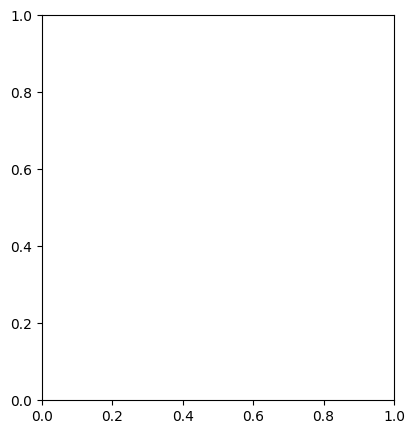

In [ ]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3]  # Example epochs, but can be more

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acces, label='Training Accuracy')
plt.plot(epochs, val_acces, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import AdamW
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import ElectraTokenizer, ElectraForSequenceClassification
from transformers import XLNetTokenizer, XLNetForSequenceClassification

dataset = load_dataset("/content/drive/MyDrive/PatentClassification/patent_classification_dataset.py")

_LABELS = [
    "Human Necessities",
    "Performing Operations; Transporting",
    "Chemistry; Metallurgy",
    "Textiles; Paper",
    "Fixed Constructions",
    "Mechanical Engineering; Lightning; Heating; Weapons; Blasting",
    "Physics",
    "Electricity",
    "General tagging of new or cross-sectional technology",
]

class CustomDataset(Dataset):
    """A custom dataset class for your patents data."""
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text,
                                  add_special_tokens=True,
                                  max_length=self.max_len,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
# 1
#model_name = "bert-base-uncased"
#tokenizer = BertTokenizer.from_pretrained(model_name)

#2
#model_name = 'distilbert-base-uncased'
#tokenizer = DistilBertTokenizer.from_pretrained(model_name)

#3
# model_name = 'google/electra-base-discriminator'
# tokenizer = ElectraTokenizer.from_pretrained(model_name)

#4
model_name = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(model_name)

train_texts, train_labels = dataset['train']['text'][:15000], dataset['train']['label'][:15000]
val_texts, val_labels = dataset['validation']['text'], dataset['validation']['label']
test_texts, test_labels = dataset['test']['text'], dataset['test']['label']

train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

import time

def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples, epoch, epochs=3):
    model = model.train()
    losses = []
    correct_predictions = 0

    progress_bar = tqdm(data_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        preds = torch.argmax(outputs.logits, dim=1)
        loss = torch.nn.CrossEntropyLoss()(outputs.logits, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': correct_predictions.item() / n_examples})

    return correct_predictions.item() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples, epoch, epochs=3):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc=f'Epoch {epoch+1}/{epochs}', leave=False)
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            preds = torch.argmax(outputs.logits, dim=1)
            loss = torch.nn.CrossEntropyLoss()(outputs.logits, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            progress_bar.set_postfix({'Loss': loss.item(), 'Accuracy': correct_predictions.item() / n_examples})

    return correct_predictions.item() / n_examples, np.mean(losses)

def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids)
            preds = torch.argmax(outputs.logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
train_acces = []
val_losses = []
val_acces = []

num_epochs = 3
for epoch in range(num_epochs):
    start_time = time.time()
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, train_loader, None, optimizer, device, len(train_dataset), epoch)
    train_losses.append(train_loss)
    train_acces.append(train_acc)
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_loader, None, device, len(val_dataset), epoch)
    val_losses.append(val_loss)
    val_acces.append(val_acc)
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    finish_time = time.time()
    print("Total time for 1 Epoch: ", (finish_time - start_time) / 60)
    print()

# Save the trained model
if '/' in model_name:
    update_name = model_name.split('/')[1]
else:
    update_name = model_name

torch.save(model.state_dict(), update_name + "_model.pt")

predictions, true_labels = get_predictions(model, test_loader, device)

# Compute metrics
accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions, target_names=_LABELS)

# Print the results
print(f"Test Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

In [ ]:
import numpy as np

lst = [1, 2, 3]

np.mean(lst)

2.0